In [1]:
# Boilerplate at top of file
%load_ext autoreload

%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
from ggplot import *


### Custom
import nltk
import sys
sys.path.append('../')
import cleaner
from feature_eng import FeatureFactory
import random
from mpl_toolkits.mplot3d import Axes3D

Loading global tagger... please wait a few seconds


In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

from sklearn.linear_model import LinearRegression,  Lasso, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

# Util Functions

In [3]:
def rmse(clf, x, y): 
    return mean_squared_error(clf.predict(x), y)**0.5
def rmse_score(clf, x, y): 
    # grid search` does maximization
    return -mean_squared_error(clf.predict(x), y)**0.5

In [4]:

def plot_over_params(grid_score, param_name, other_param_settings = dict(), transform_y=lambda y: -1*y):
    x = []
    y = []
    for gs in grid_score:
        valid_entry = True
        for k in other_param_settings.keys():
            if gs.parameters.has_key(k):
                if gs.parameters[k] != other_param_settings[k]:
                    valid_entry=False
                    break
        if valid_entry:
            x.append(gs.parameters[param_name])
            y.append(transform_y(gs.mean_validation_score))
            
    plt.plot(x,y)
    plt.xlabel(param_name)

In [5]:

def plot_3d_over_params(grid_score, param_name_x,param_name_y, other_param_settings = dict(), transform_y=lambda y: -1*y):
    x = []
    y = []
    z = []
    for gs in grid_score:
        valid_entry = True
        for k in other_param_settings.keys():
            if gs.parameters.has_key(k):
                if gs.parameters[k] != other_param_settings[k]:
                    valid_entry=False
                    break
        if valid_entry:
            x.append(gs.parameters[param_name_x])
            y.append(gs.parameters[param_name_y])            
            z.append(transform_y(gs.mean_validation_score))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.xlabel(param_name_x)
    plt.ylabel(param_name_y)
    return (x,y,z)

# Experiment

In [6]:
ff = FeatureFactory(set_params=False)

In [7]:
df_train_full = pd.read_csv('../data/train_features/train_features_full.csv')

# smaller ssample size for test_purposes

df_train = df_train_full


In [8]:
df_train = df_train.iloc[random.sample(df_train.index,2000)].reset_index()



In [9]:
df_train= pd.read_csv('../data/train_sample_features.csv')

In [10]:
# df_train = pd.read_csv('../data/esa_features_sample.csv')
# df_train = df_train.fillna(0)

In [11]:
## Constants
Y_KEY = 'relevance'
feat_cols = ff.get_feature_names()
# feat_cols = feat_cols + ['ESA_0', 'ESA_025', 'ESA_05', 'ESA_075', 'ESA_Max', 'Is_High_ESA']

In [228]:
# from itertools import combinations
# list(combinations(feat_cols, 2))
# def generate_interaction_effects(df, feat_cols):
    
#     for col_0, col_1 in combinations(feat_cols, 2):
#         new_col = '%s_with_%s' % (col_0, col_1)
#         df[new_col] = np.multiply(df[col_0], df[col_1])
#         feat_cols.append(new_col)
#     return feat_cols
# feat_cols = generate_interaction_effects(df_train, feat_cols)        

In [229]:
def apse_k_fold(clfs, x, y, k = 10, 
                m_metric = lambda x,y : mean_squared_error(x,y)**0.5,
                verbose=False,
               feature_selection = lambda df, x_col, y_col: (np.array(df[x_col]), np.array(df[y_col]))
               ):
    # all uses the same folds
    # for RMSE
    n = len(y)

    X = np.array(x)
    y = np.array(y)

    print X.shape
    kf = KFold(n, n_folds=k)

#     X = np.array(df[x_col])
#     y = np.array(df[y_col])
    results = []
    for clf in clfs:
        if verbose:
            print '%s-Fold Cross Validation for %s' % (k, clf.__class__.__name__)
        fm = clone(clf).fit(X, y)
        apses = []
        varias =  []
        for train_index, test_index in kf:
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            fm_y_pred = fm.predict(X_test)
            var = m_metric(y_test, fm_y_pred)
            apse = m_metric(y_test, y_pred)
            apses.append(apse)
            varias.append(var)
#             mse = m_metric(fm_y_pred, y_)
            if verbose:
                print "APSE", apse, "Variance", var
        results.append(dict(
            classifier = clf.__class__.__name__,
            params = clf.get_params(),
            apse_mean = np.mean(apses),
            var_mean = np.mean(varias),
            ))
    return pd.DataFrame(results)
from sklearn.feature_selection import f_regression
def feature_selection(df, x_col, y_col):
    kbest = SelectKBest(f_regression, k=5)
    X =  kbest.fit_transform(df[x_col], df[y_col])
    Y = df[y_col]
    return X,Y

In [230]:
rf = RandomForestRegressor()
lm = LinearRegression()
lasso = LassoCV()
gbr = GradientBoostingRegressor()
bgr = BaggingRegressor()
knn = KNeighborsRegressor()
# apse_k_fold(rf, df_train, feat_cols, Y_KEY)


df_res = apse_k_fold(
    [rf, lm, lasso, gbr, bgr, knn], 
#     [svr],
    df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)
df_res

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.509441,RandomForestRegressor,"{u'warm_start': False, u'oob_score': False, u'...",0.209238
1,0.486775,LinearRegression,"{u'copy_X': True, u'normalize': False, u'n_job...",0.466571
2,0.485568,LassoCV,"{u'normalize': False, u'alphas': None, u'n_job...",0.478922
3,0.486304,GradientBoostingRegressor,"{u'warm_start': False, u'loss': u'ls', u'verbo...",0.353608
4,0.522135,BaggingRegressor,"{u'max_samples': 1.0, u'base_estimator': None,...",0.213956
5,0.567658,KNeighborsRegressor,"{u'n_neighbors': 5, u'algorithm': u'auto', u'm...",0.453594


# visualize

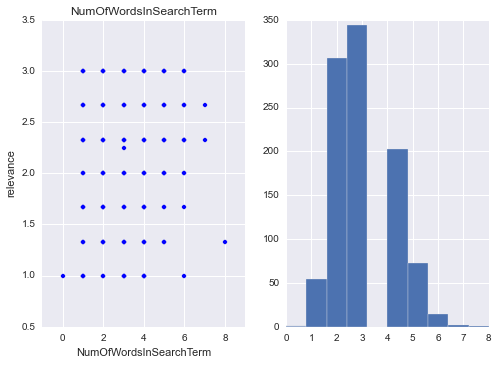

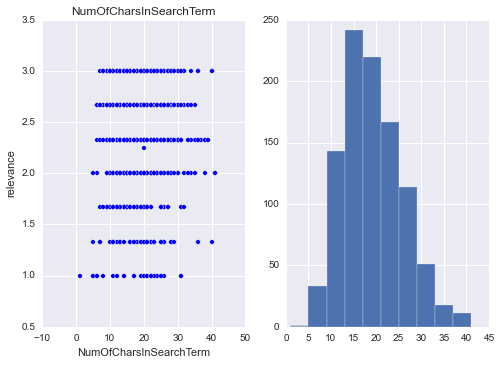

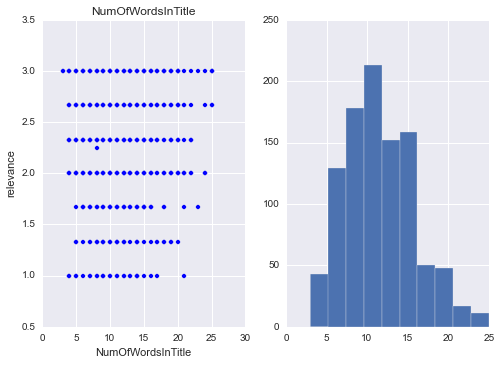

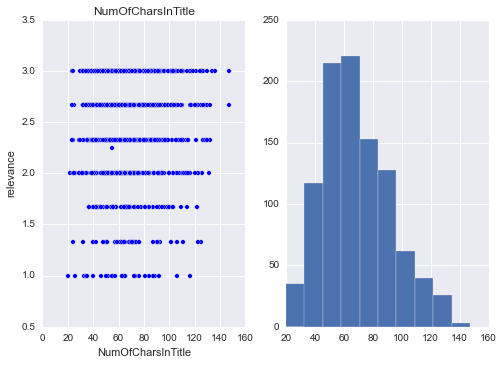

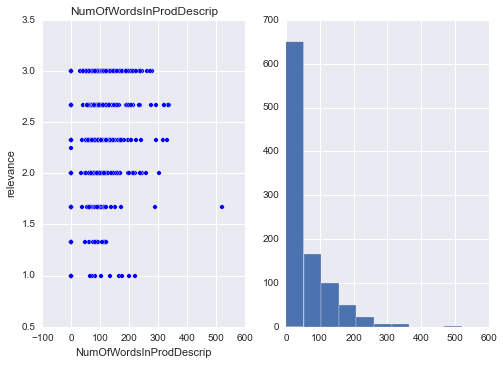

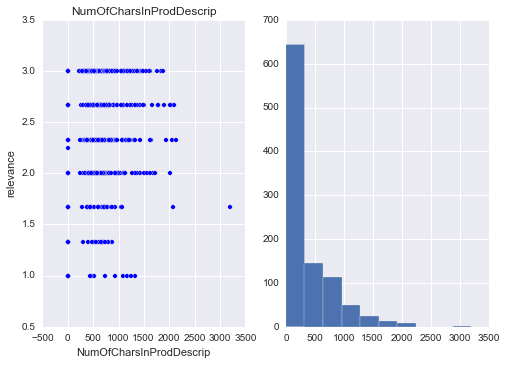

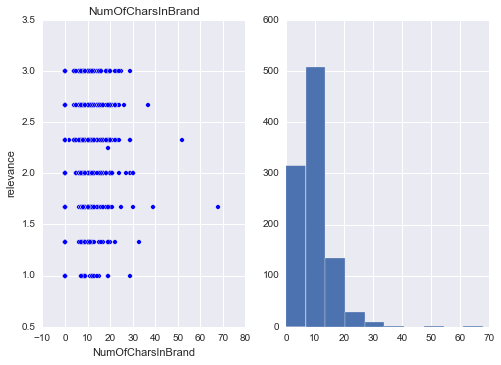

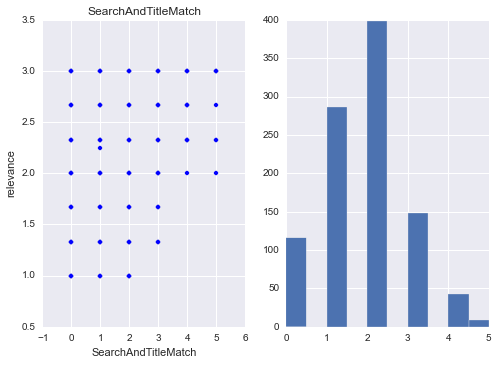

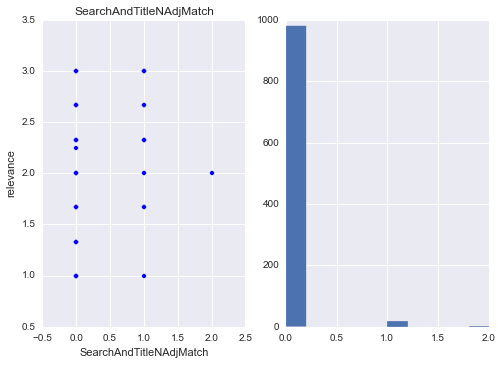

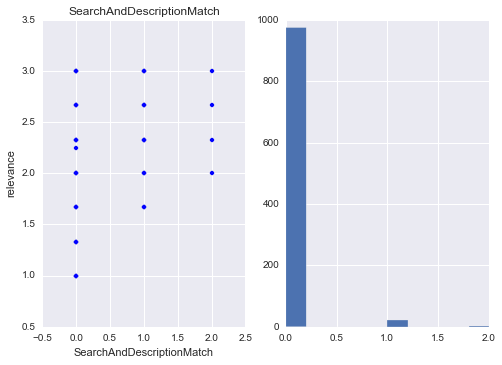

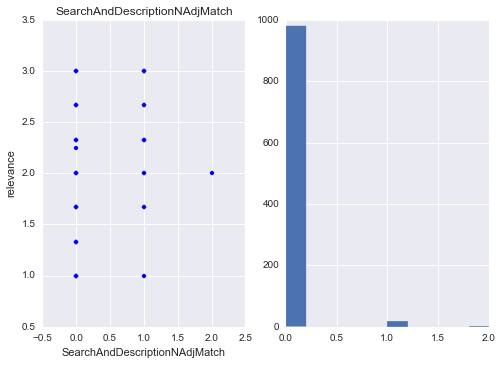

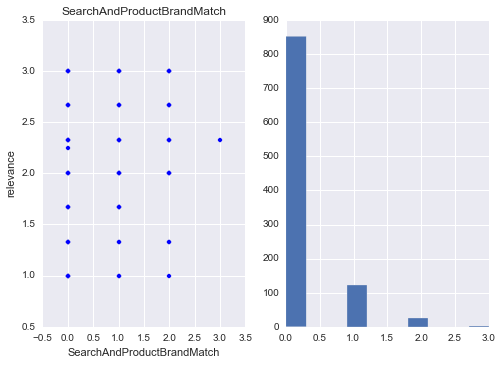

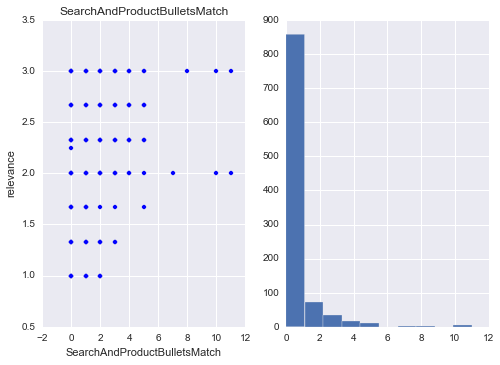

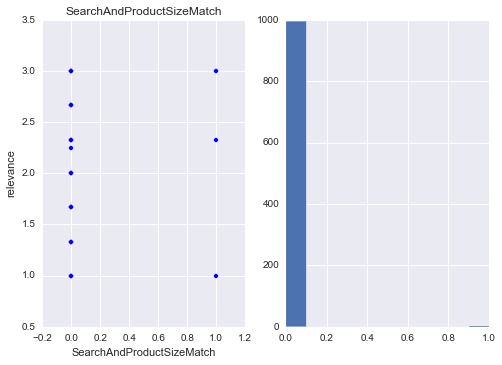

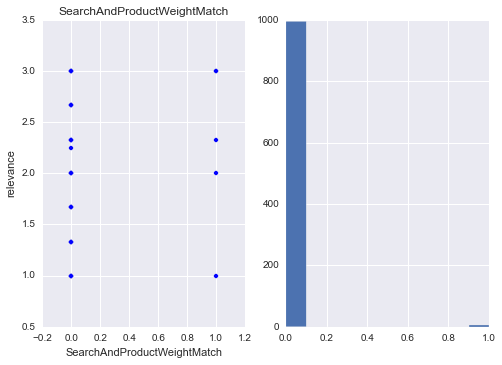

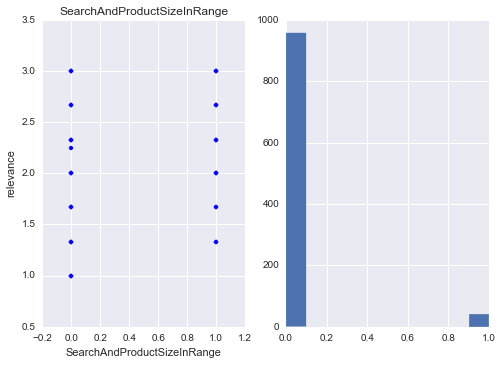

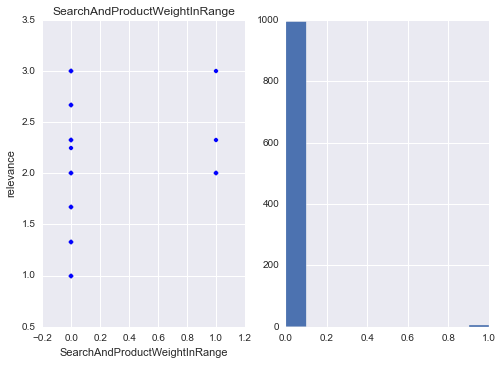

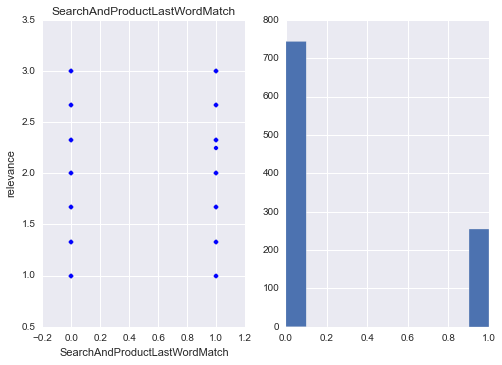

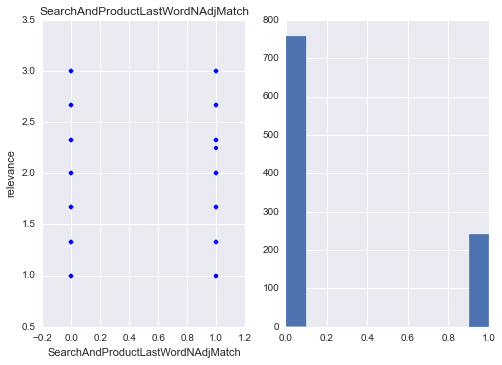

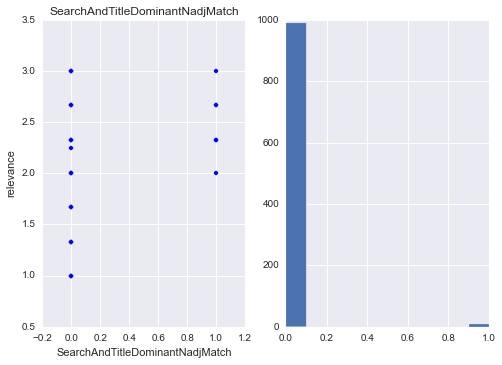

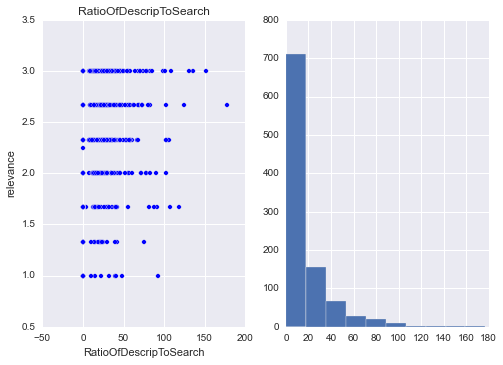

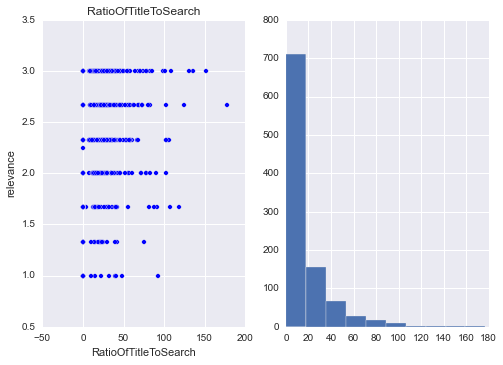

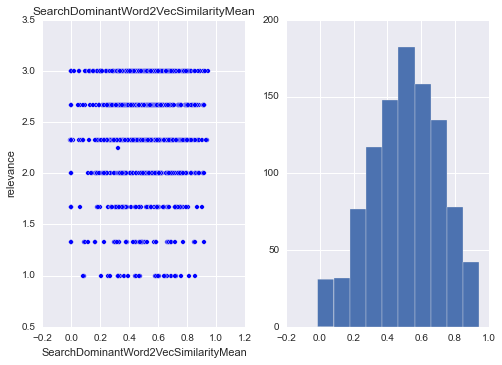

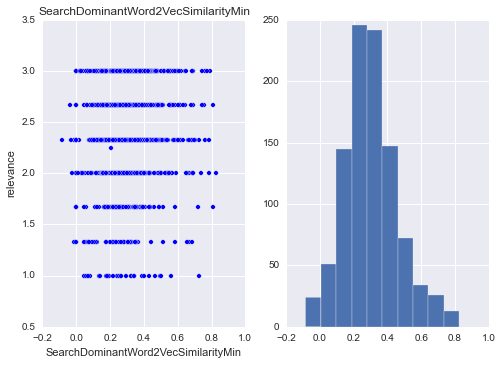

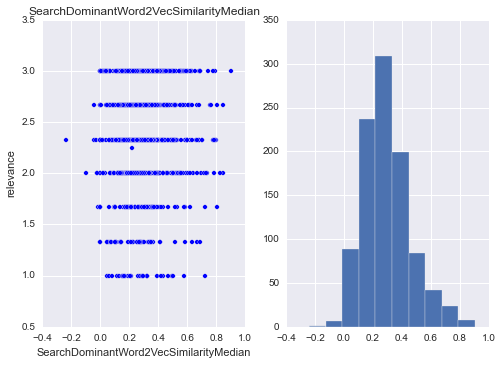

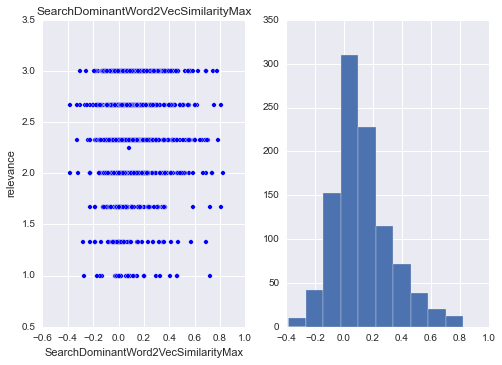

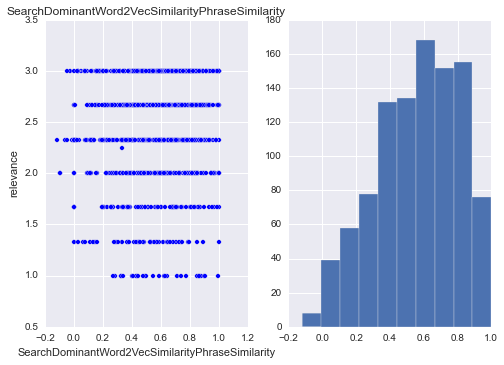

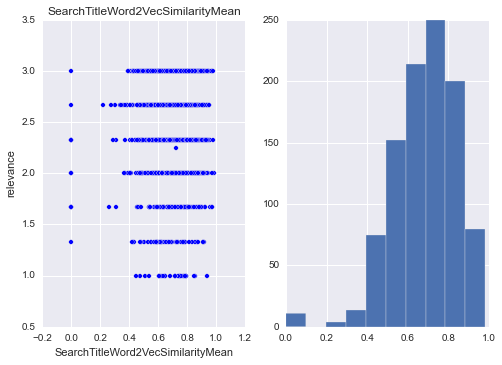

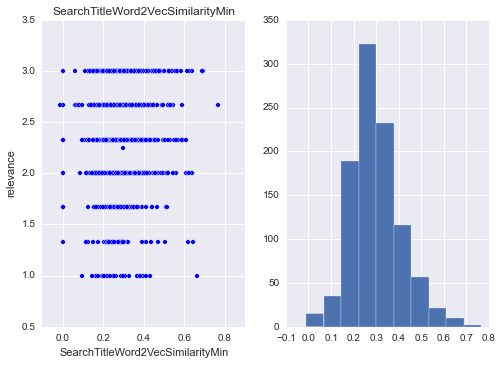

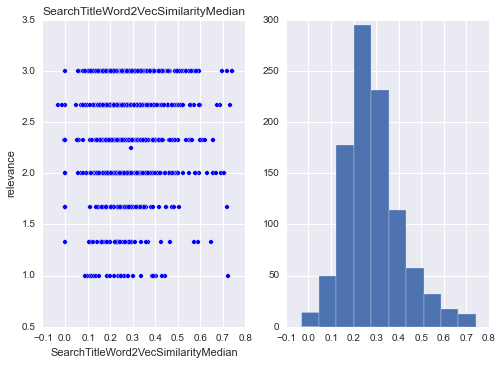

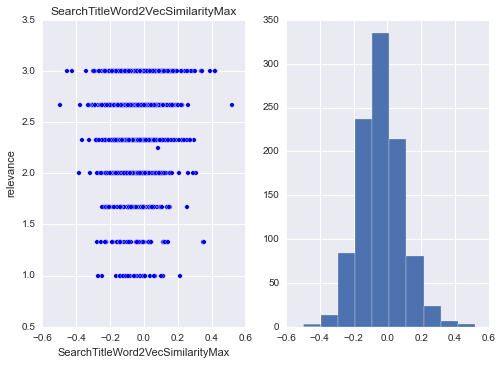

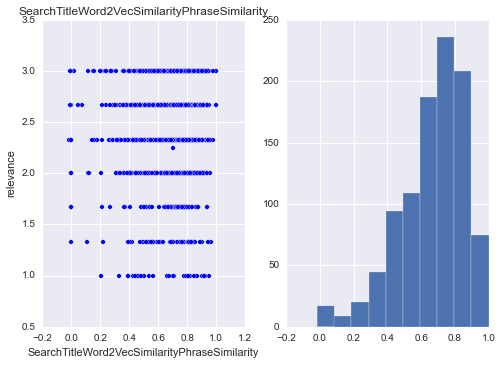

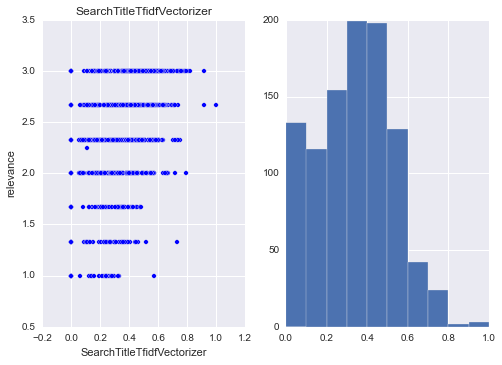

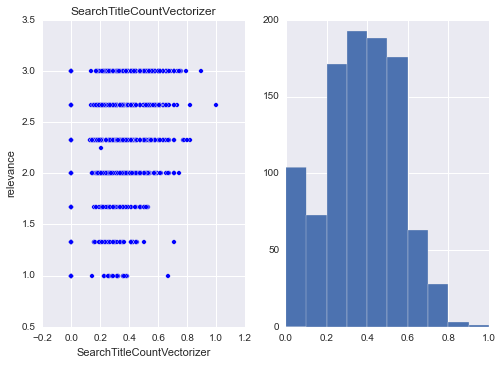

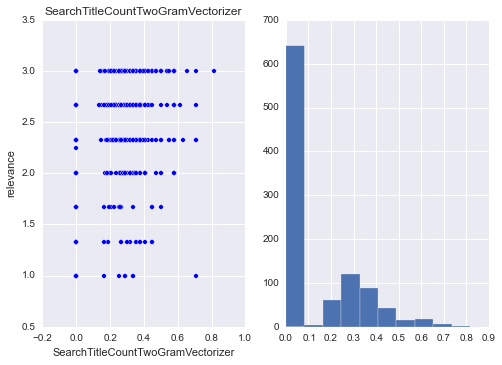

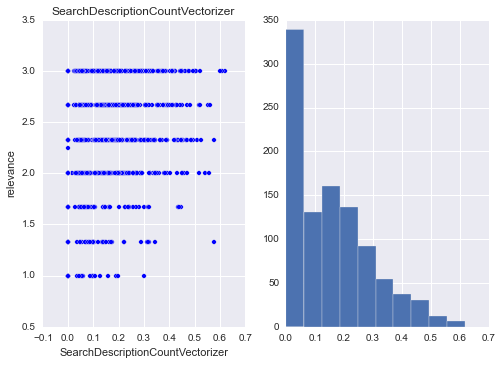

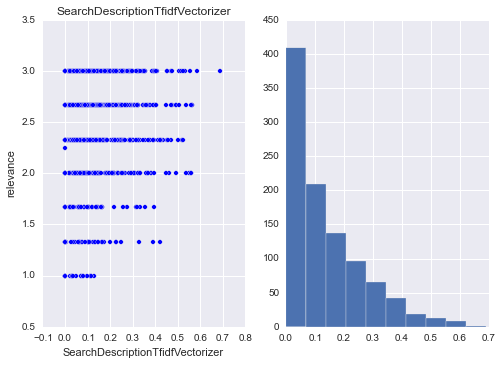

In [231]:
for f in feat_cols:
    plt.figure()
    plt.subplot(121)
    plt.scatter(df_train[f], df_train[Y_KEY])
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel(Y_KEY)
    plt.subplot(122)
    plt.hist(df_train[f])

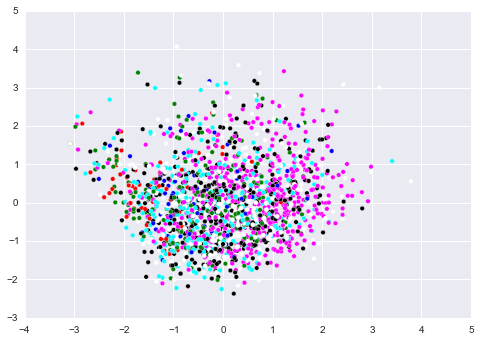

In [217]:
from sklearn.lda import LDA
from sklearn.decomposition import TruncatedSVD,PCA

lda = LDA()
svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)
X, Y = feature_selection(df_train, feat_cols, Y_KEY)
# Y = np.round(Y) - 1
from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)
X = lda.fit_transform(X,Y)

colors=['red', 'blue', 'green', 'cyan', 'black', 'white', 'magenta', 'grey']
plt.scatter(X[:,0], X[:,1], c = map(lambda x: colors[int(x)], Y))

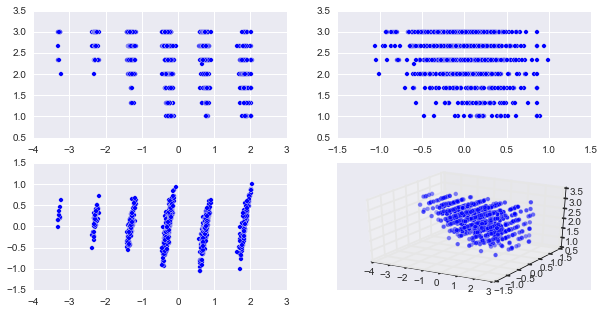

In [17]:
from mpl_toolkits.mplot3d import Axes3D
def decomp_scatter_3d(X, Y, decomp):
    args = [Y]
    X_decomp = decomp.fit_transform(X,*args)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(221)
    ax.scatter(X_decomp[:,0], Y)
    ax = fig.add_subplot(222)    
    ax.scatter(X_decomp[:,1], Y)
    ax = fig.add_subplot(223)    
    ax.scatter(X_decomp[:,0], X_decomp[:,1])
    
    
    ax = fig.add_subplot(224, projection='3d')
    ax.scatter(X_decomp[:,0], X_decomp[:,1], Y)
X_min  = SelectKBest(f_regression, k = 10).fit_transform(df_train[feat_cols], df_train[Y_KEY])

decomp_scatter_3d(X_min,df_train[Y_KEY], pca)

# Gradient Boosting Regression

In [232]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', GradientBoostingRegressor())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
    'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_boost = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_boost.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 155 candidates, totalling 465 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 200 jobs       | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 450 jobs       | elapsed:   16.6s
[Parallel(n_jobs=5)]: Done 457 out of 465 | elapsed:   17.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done 465 out of 465 | elapsed:   17.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x113e07d70>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'clf__n_estimators': [20, 30, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x1180bdde8>, verbose=1)

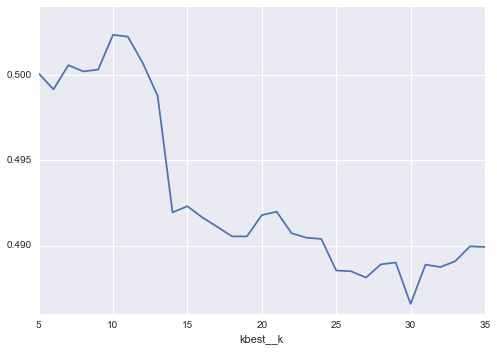

In [233]:
plot_over_params(gs_boost.grid_scores_, 'kbest__k', dict(clf__n_estimators = 30))

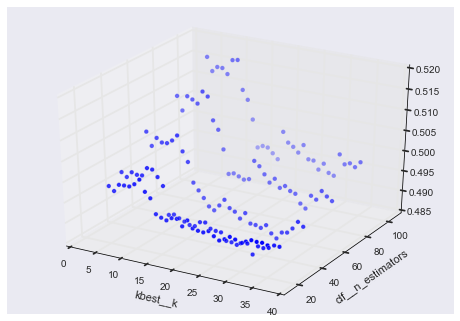

In [234]:
x,y,z = plot_3d_over_params(gs_boost.grid_scores_, 'kbest__k', 'clf__n_estimators')

In [235]:
gs_boost.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=30, score_func=<function f_regression at 0x113e07d70>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [236]:
apse_k_fold([gs_boost.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.477798,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 30,...",0.419033
1,0.489168,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 100...",0.388097


In [237]:
best_estimator = gs_boost.best_estimator_

# Neurel Net

In [273]:
from sklearn.neural_network import BernoulliRBM

In [275]:

steps = [('rbm', BernoulliRBM()),
        ('clf', GradientBoostingRegressor())]
pipeline = Pipeline(steps)
apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY])

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.525968,Pipeline,"{u'clf__warm_start': False, u'clf__verbose': 0...",0.52485


# Fuzzy Inference

In [14]:
import fuzzy

ImportError: dlopen(/usr/local/lib/python2.7/site-packages/mlabrawmodule.so, 2): Library not loaded: @rpath/libeng.dylib
  Referenced from: /usr/local/lib/python2.7/site-packages/mlabrawmodule.so
  Reason: image not found

# Linear Regression

In [238]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', LinearRegression())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
#     'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_lm = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_lm.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 31 candidates, totalling 93 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  85 out of  93 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  93 out of  93 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x113e07d70>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x1180bdde8>, verbose=1)

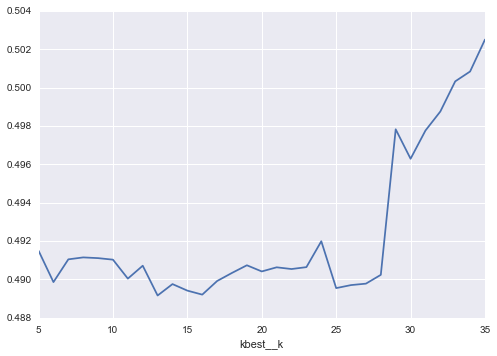

In [239]:
plot_over_params(gs_lm.grid_scores_, 'kbest__k')

In [240]:
apse_k_fold([gs_lm.best_estimator_,pipeline], df_train[feat_cols], df_train[Y_KEY])

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.483938,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.471748
1,0.485361,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.474635


# Random Forest

In [241]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', RandomForestRegressor())]
params = {
    'kbest__k' : list(xrange(20,len(feat_cols)-1)),
#     'clf__n_estimators' : [30],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_rf = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1, scoring=rmse_score)
gs_rf.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x113e07d70>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kbest__k': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x1180bdde8>, verbose=1)

In [242]:
gs_rf.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=31, score_func=<function f_regression at 0x113e07d70>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [243]:
apse_k_fold([gs_rf.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.513664,Pipeline,"{u'clf__n_estimators': 10, u'clf__warm_start':...",0.21331
1,0.519485,Pipeline,"{u'clf__n_estimators': 10, u'clf__warm_start':...",0.22708


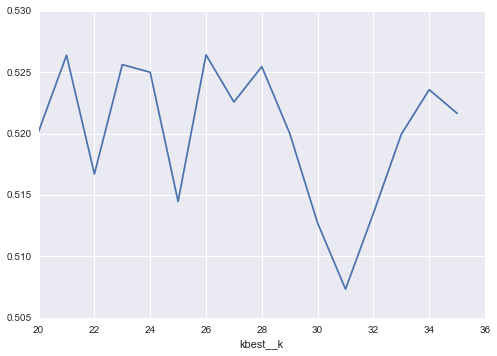

In [244]:
plot_over_params(gs_rf.grid_scores_, 'kbest__k')

# KNN Regression

In [245]:
KNeighborsRegressor(n)

NameError: name 'n' is not defined

In [246]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', KNeighborsRegressor())]
params = {
    'kbest__k' : list(xrange(4,len(feat_cols)-1)),
    'clf__n_neighbors' : list(xrange(1,10)),
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_knn = GridSearchCV(pipeline, params, verbose=1, scoring=rmse_score)
gs_knn.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:    5.9s finished


Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x113e07d70>)), ('clf', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kbest__k': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x1180bdde8>, verbose=1)

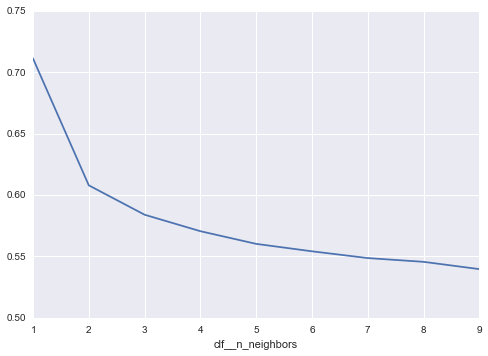

In [247]:
plot_over_params(gs_knn.grid_scores_, 'clf__n_neighbors', other_param_settings=dict(kbest__k = 11))

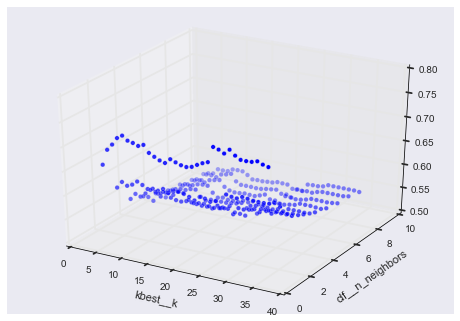

In [248]:
x,y,z = plot_3d_over_params(gs_knn.grid_scores_, 'kbest__k', 'clf__n_neighbors')

In [249]:
apse_k_fold([gs_knn.best_estimator_, pipeline],
           df_train[feat_cols],
           df_train[Y_KEY]
           )

(1000, 37)


,apse_mean,classifier,params,var_mean
0,0.511001,Pipeline,"{u'clf__metric': u'minkowski', u'clf__metric_p...",0.458293
1,0.523176,Pipeline,"{u'clf__metric': u'minkowski', u'clf__metric_p...",0.419156


# Make a Submission

In [250]:
apse_k_fold([best_estimator],
           df_train_full[feat_cols],
           df_train_full[Y_KEY]
           )

(74067, 37)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [46]:

best_estimator.fit(df_train_full[feat_cols], df_train_full[Y_KEY])

Pipeline(steps=[('kbest', SelectKBest(k=22, score_func=<function f_regression at 0x10e8d8cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [47]:
df_test = pd.read_csv('../data/test_features/test_features_full.csv')

In [48]:
y_test = best_estimator.predict(df_test[feat_cols])

(array([  56.,   90.,    0.,  187.,    0.,  314.,  408.,    2.,  426.,  517.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

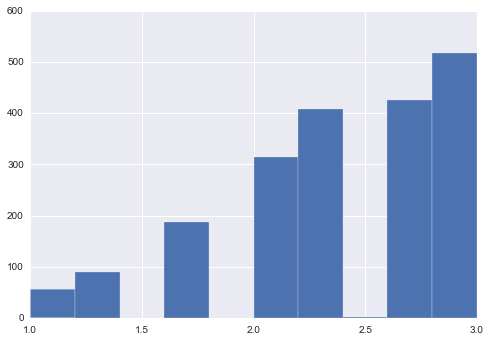

In [49]:
plt.hist(np.power(df_train[Y_KEY],1))

(array([   863.,   3945.,   8777.,  20619.,  27535.,  30208.,  30232.,
         23026.,  16782.,   4706.]),
 array([ 1.85424446,  1.94769979,  2.04115511,  2.13461044,  2.22806576,
         2.32152108,  2.41497641,  2.50843173,  2.60188706,  2.69534238,
         2.78879771]),
 <a list of 10 Patch objects>)

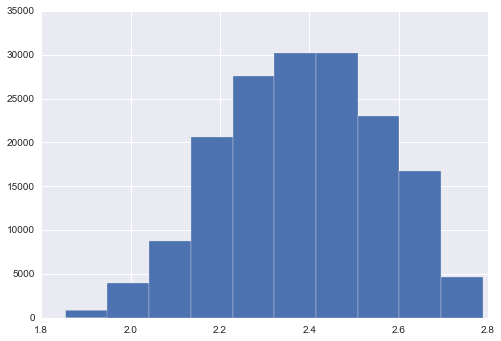

In [50]:
plt.hist(y_test)

In [51]:
df_test_submission = pd.DataFrame(dict(id = df_test['id'], relevance=y_test))

In [52]:
df_test_submission.to_csv('submission.csv', index=False)

In [53]:
df_test_raw = pd.read_csv('../data/test.csv')

In [42]:
df_test_joined = pd.read_csv('../data/test_joined.csv')

In [43]:
ids_a = set(df_test_joined['id'].tolist())
ids_b = set(df_test_raw['id'].tolist())

In [44]:
ids_a.difference(ids_b)

set()